In [1]:
import os, sys
sys.path.insert(0, os.path.abspath("../scr"))
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sbi import analysis as analysis
from sbi.inference import prepare_for_sbi

In [2]:
from simulator import smfe_simulator_mm
from gls_spline import gls_spline
import config

In [3]:
observation = torch.load('../../sbi_for_smfs/splines_model/analysis/data/observation_spline.pt')
true_parameters = torch.load('../../sbi_for_smfs/splines_model/analysis/data/parameters_spline.pt')

In [4]:
D = true_parameters[0].item()
k = true_parameters[1].item()

In [5]:
x_knots = np.linspace(config.min_x, config.max_x, config.N_knots)
y_knots_true = np.zeros(config.N_knots)
y_knots_true[0] = y_knots_true[-1] = config.max_G_0
y_knots_true[1] = y_knots_true[-2] = config.max_G_1
for i in range(config.N_knots_prior):
    y_knots_true[i + (config.N_const_knots // 2)] = true_parameters[i + 2]

In [6]:
x_axis = np.linspace(config.min_x, config.max_x, 1000)
true_y = gls_spline(x_knots, y_knots_true, x_axis)

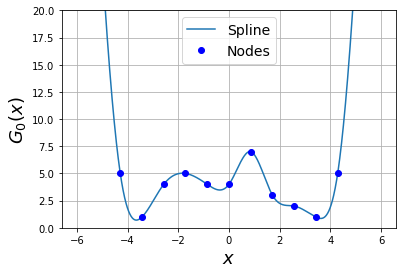

In [7]:
plt.plot(x_axis, true_y, label='Spline')
plt.plot(x_knots, y_knots_true, 'ob', label='Nodes')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$G_0(x)$', fontsize=18)
plt.legend(fontsize=14)
plt.ylim(0, 20)
plt.grid(True)

In [8]:
with open(f'../data/posteriors/armortized_posterior.pkl', 'rb') as handle:
    posterior_sequential = pickle.load(handle)

In [9]:
with open(f'../data/posteriors/armortized_posterior_no_zscoring.pkl', 'rb') as handle:
    posterior_amortized = pickle.load(handle)

In [10]:
samples_seq = posterior_sequential.sample((100000,), x=observation).cpu()
samples_arm = posterior_amortized.sample((100000,), x=observation).cpu()

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

/home/dingeldein/anaconda3/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  outputs, _ = torch.triangular_solve(


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
# Removing shifts along y-axis
samples_seq[:, 2:] = samples_seq[:, 2:] - torch.mean(samples_seq[:, 2:], dim=1).reshape(-1, 1) + torch.mean(true_parameters[2:])
samples_arm[:, 2:] = samples_arm[:, 2:] - torch.mean(samples_arm[:, 2:], dim=1).reshape(-1, 1) + torch.mean(true_parameters[2:])

In [12]:
labels = [r'$D_q/D_x$', r'$\kappa$', *[f'Spline {i}' for i in range(11)]]
limits = [config.logD_lims, config.k_lims, *[config.spline_lims for i in range(11)]]
#_ = analysis.pairplot(samples.cpu(), figsize=(20, 20), points=true_parameters, points_offdiag={'markersize': 6}, points_colors='r', labels=labels)

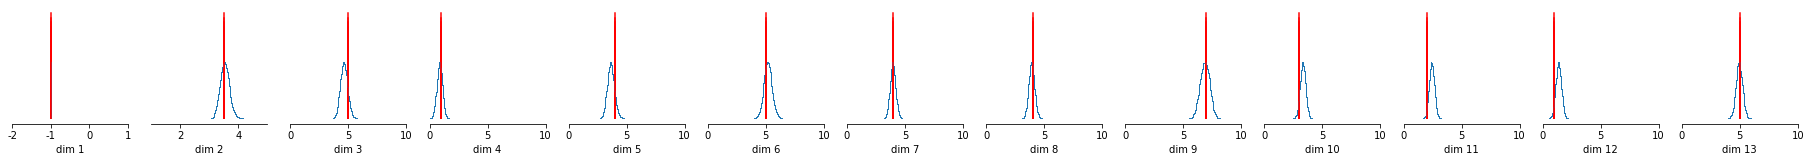

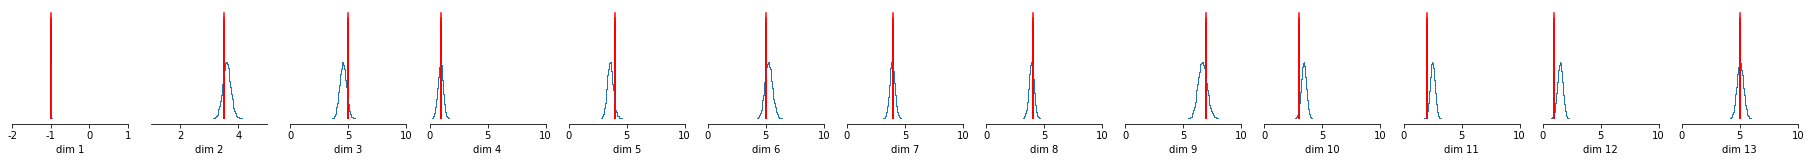

In [13]:
_ = analysis.marginal_plot(samples_seq.cpu(), points=true_parameters, points_colors='r', figsize=(32, 2), limits=limits)
_ = analysis.marginal_plot(samples_arm.cpu(), points=true_parameters, points_colors='r', figsize=(32, 2), limits=limits)

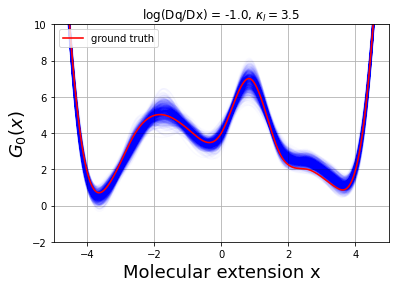

In [14]:
# Plotting individual posterior samples
for sample in samples_seq[torch.randperm(50000)[:1000]].cpu():
    y_knots = config.max_G_0 * np.ones(config.N_knots)
    y_knots[1] = y_knots[-2] = 30
    y_knots[2:-2] = sample[2:].numpy()
    y_axis = gls_spline(x_knots, y_knots, x_axis)
    plt.plot(x_axis, y_axis, alpha=0.02, color='blue')
    plt.ylim(-2, 10)
    plt.xlim(-5, 5)
plt.title(f'log(Dq/Dx) = {D}, $\kappa_l = {k}$')
plt.plot(x_axis, true_y, color='red', linewidth=1.6, label='ground truth')
plt.xlabel(r'Molecular extension x', fontsize=18)
plt.ylabel(r'$G_0(x)$', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)

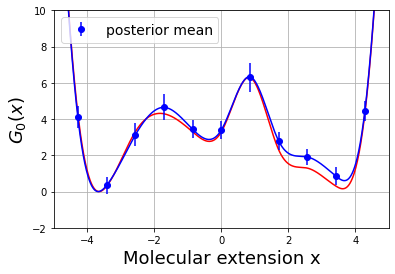

: 

In [20]:
# Plotting the posterior mean
mean_posterior = torch.mean(samples_seq.cpu(), dim=0)

#y_axis = gls_spline(x_knots, y_knots, x_axis)
#true_y = gls_spline(x_knots, y_true, x_axis)
#plt.plot(x_axis, true_y - np.min(true_y), color='red', linewidth=1.6, label='ground truth')
plt.plot(x_axis, true_y - np.min(true_y), color='red')

y_knots = config.max_G_0 * np.ones(config.N_knots)
y_knots[1] = y_knots[-2] = 30
y_knots[2:-2] = mean_posterior[2:].numpy()
y_knots_err = np.zeros((2, config.N_knots))
y_knots_err[:, 2:-2] = np.abs(np.quantile(samples_seq.cpu().numpy(), [0.025, 0.975], axis=0)[:, 2:] - mean_posterior[2:].numpy())
y_axis = gls_spline(x_knots, y_knots, x_axis)
plt.plot(x_axis, y_axis - np.min(y_axis), alpha=1, color='blue')
plt.errorbar(x_knots, y_knots - np.min(y_axis), yerr=y_knots_err, linestyle='', marker='o', color='blue', label='posterior mean')

#plt.title(f'log(Dq/Dx) = {D}, $\kappa_l$ = {k}')
plt.xlabel(r'Molecular extension x', fontsize=18)
plt.ylabel(r'$G_0(x)$', fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.ylim(-2, 10)
plt.xlim(-5, 5)
plt.grid(True)

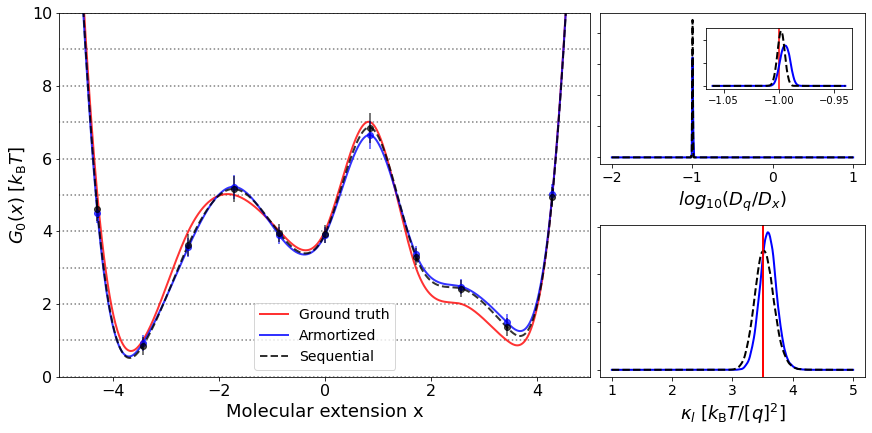

In [18]:
x = 4
fig = plt.figure(constrained_layout=True, figsize=(3*x, 2*x))
fig.tight_layout()
fontsize = 13

ax3 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax1 = plt.subplot2grid((3, 3), (0, 2))
ax2 = plt.subplot2grid((3, 3), (1, 2))

ax1.set_yticklabels([])
ax1.set_xlabel('$log_{10}(D_q/D_x)$', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
axins = ax1.inset_axes((0.4, 0.5, 0.55, 0.4))
axins.axvline(x=D, ymin=0, ymax=1, color='r')
axins.set_yticklabels([])

ax2.set_yticklabels([])
ax2.set_xlabel(r'$\kappa_l$ [$k_{\mathrm{B}}T/[q]^2$]', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.axvline(x=k, ymin=0, ymax=1, color='r')

#ax3.plot(x_knots, y_knots, linestyle='', marker='o', color='blue')
for hline in np.arange(-0, 16, 1):
    ax3.axhline(hline, -3.5, 3.5, linestyle=':', color='gray')
ax3.set_xlabel('Molecular extension x', fontsize=18)
ax3.set_ylabel(r'$G_0(x)$ [$k_{\mathrm{B}}T$]', fontsize=18)
ax3.set_ylim(-0, 10)
ax3.set_xlim(-5, 5)
ax3.tick_params(axis='both', which='major', labelsize=16)

x_axis = np.linspace(config.min_x, config.max_x, 1000)
x_knots = np.linspace(config.min_x, config.max_x, config.N_knots)
y_knots_true = np.zeros(config.N_knots)
y_knots_true[0] = y_knots_true[-1] = config.max_G_0
y_knots_true[1] = y_knots_true[-2] = config.max_G_1
for i in range(config.N_knots_prior):
    y_knots_true[i + (config.N_const_knots // 2)] = true_parameters[i + 2]
true_y = gls_spline(x_knots, y_knots_true, x_axis)

ax3.plot(x_axis, true_y, color='red', linewidth=2., label='Ground truth', alpha=0.8)

#traj_axins = ax3.inset_axes((0.15, 0.7, 0.37, 0.25))
#traj_axins.set_xticklabels([])
#traj_axins.set_yticklabels([])
#traj_axins.scatter(range(len(traj_q[::50])), traj_q[::50], s=0.03)
#traj_axins.set_xlabel('Time', fontsize=14)
#traj_axins.set_ylabel('q', fontsize=14)

for idx, samples in enumerate([samples_arm, samples_seq]):
    color = 'black' if idx == 1 else 'blue'
    label = 'Sequential' if idx == 1 else 'Armortized'
    linestyle = '--' if idx == 1 else '-'
    
    mean_posterior = torch.mean(samples.cpu(), dim=0)
    confidence_intervall = np.quantile(samples.cpu().numpy(), [0.16, 0.84], axis=0)
    confidence_mass = [
        generate_kde(
            samples[:, i], confidence_intervall[:, i]
        ) 
        for i in range(2)
    ]

    ax1.plot(*generate_kde(samples.cpu()[:, 0].numpy(), config.logD_lims), linewidth=2, color=color, linestyle=linestyle)
    axins.plot(*generate_kde(samples.cpu()[:, 0].numpy(), (-1.06, -0.94)), linewidth=2, color=color, linestyle=linestyle)

    ax2.plot(*generate_kde(samples.cpu()[:, 1].numpy(), config.k_lims), linewidth=2, color=color, linestyle=linestyle)
    ax2.set_yticklabels([])
    ax2.set_xlabel(r'$\kappa_l$ [$k_{\mathrm{B}}T/[q]^2$]', fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.axvline(x=k, ymin=0, ymax=1, color='r')

    y_knots = config.max_G_0 * np.ones(config.N_knots)
    y_knots[2:-2] = mean_posterior[2:].cpu().numpy()
    y_knots[1] = y_knots[-2] = 30
    y_knots_err = np.zeros((2, config.N_knots))
    y_knots_err[:, 2:-2] = np.abs(np.quantile(samples.cpu().numpy(), [0.16, 0.84], axis=0)[:, 2:] - mean_posterior[2:].numpy())
    y_axis = gls_spline(x_knots, y_knots, x_axis)
    ax3.errorbar(x_knots, y_knots, yerr=y_knots_err, linestyle='', marker='o', color=color, alpha=0.7)
    ax3.plot(x_axis, y_axis, color=color,linewidth=2. ,label=label, alpha=0.8, linestyle=linestyle)
ax3.legend(fontsize=14)

In [17]:
import scipy.stats as stats
def generate_kde(samples, limits):
    kde_xs = np.linspace(limits[0], limits[1], 300)
    kde = stats.gaussian_kde(samples)
    return kde_xs, kde.pdf(kde_xs)

In [ ]:
samples = samples_seq

In [ ]:
x = 4
fig = plt.figure(figsize=(3*x, 2*x))

ax3 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax1 = plt.subplot2grid((3, 3), (0, 2))
ax2 = plt.subplot2grid((3, 3), (1, 2))

ax1.set_yticklabels([])
#ax1.set_ylabel('$p(D_q/D_x|q_t)$', fontsize=18)
ax1.set_xlabel('$log_{10}(D_q/D_x)$', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
axins = ax1.inset_axes((0.4, 0.5, 0.55, 0.4))
axins.axvline(x=D, ymin=0, ymax=1, color='r')
axins.set_yticklabels([])

ax2.set_yticklabels([])
#ax2.set_ylabel('$p(\kappa_l|q_t)$', fontsize=18)
ax2.set_xlabel(r'$\kappa_l$ [$k_{\mathrm{B}}T/[q]^2$]', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.axvline(x=k, ymin=0, ymax=1, color='r')

#ax3.plot(x_knots, y_knots, linestyle='', marker='o', color='blue')
for hline in np.arange(-0, 16, 1):
    ax3.axhline(hline, -3.5, 3.5, linestyle=':', color='gray')
ax3.set_xlabel('Molecular extension x', fontsize=18)
ax3.set_ylabel(r'$G_0(x)$ [$k_{\mathrm{B}}T$]', fontsize=18)
ax3.set_ylim(-0, 10)
ax3.set_xlim(-5, 5)
ax3.tick_params(axis='both', which='major', labelsize=16)

for idx, samples in enumerate([samples_seq, samples_arm]):
    color = 'orange' if idx == 0 else 'blue'
    label = 'Sequential 1' if idx == 0 else 'Sequential 2'
    
    mean_posterior = torch.mean(samples.cpu(), dim=0)
    confidence_intervall = np.quantile(samples.cpu().numpy(), [0.16, 0.84], axis=0)
    confidence_mass = [
        generate_kde(
            samples[:, i], confidence_intervall[:, i]
        ) 
        for i in range(2)
    ]

    ax1.plot(*generate_kde(samples.cpu()[:, 0].numpy(), config.logD_lims), linewidth=2, color=color)
    axins.plot(*generate_kde(samples.cpu()[:, 0].numpy(), (-1.06, -0.94)), linewidth=2, color=color)

    ax2.plot(*generate_kde(samples.cpu()[:, 1].numpy(), config.k_lims), linewidth=2, color=color)
    ax2.set_yticklabels([])
    #ax2.set_ylabel('$p(\kappa_l|q_t)$', fontsize=18)
    ax2.set_xlabel(r'$\kappa_l$ [$k_{\mathrm{B}}T/[q]^2$]', fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.axvline(x=k, ymin=0, ymax=1, color='r')

    y_knots = config.max_G_0 * np.ones(config.N_knots)
    y_knots[2:-2] = mean_posterior[2:].cpu().numpy()
    y_knots[1] = y_knots[-2] = 30
    y_knots_err = np.zeros((2, config.N_knots))
    y_knots_err[:, 2:-2] = np.abs(np.quantile(samples.cpu().numpy(), [0.16, 0.84], axis=0)[:, 2:] - mean_posterior[2:].numpy())
    y_axis = gls_spline(x_knots, y_knots, x_axis)
    ax3.errorbar(x_knots, y_knots, yerr=y_knots_err, linestyle='', marker='o', color=color, alpha=0.8)
    ax3.plot(x_axis, y_axis, color=color,linewidth=2. ,label=label, alpha=0.8)
    #ax3.plot(x_knots, y_knots, linestyle='', marker='o', color='blue')
    
ax3.plot(x_axis, true_y, color='red', linewidth=2., label='Ground truth', alpha=0.8)
ax3.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('posterior_comparison.pdf', dpi=500)

In [ ]:
fig, axes = plt.subplots(6, 13, figsize=(20, 10), sharex='col')

for ax_idx in range(6):
    for param_idx in range(samples_seq.size(1)):
        axes[ax_idx][param_idx].axvline(x=true_parameters[param_idx].item(), ymin=0, ymax=1, color='r')

with open(f'../scr/mmatrix_posterior.pkl', 'rb') as handle:
    posterior_amortized = pickle.load(handle)
samples_arm = posterior_amortized.sample((500000,), x=observation)
samples_arm[:, 2:] = samples_arm[:, 2:] - torch.mean(samples_arm[:, 2:], dim=1).reshape(-1, 1) + torch.mean(true_parameters[2:])
for param_idx in range(samples_arm.size(1)):
    axes[0][param_idx].plot(*generate_kde(samples_arm.cpu()[:, param_idx].numpy(), limits[param_idx]))
    axes[0][param_idx].set_xlim(limits[param_idx])
    axes[0][param_idx].set_yticklabels([])


for ax_idx, round_idx in zip(range(1, 6), [0, 4, 9, 14, 19]):
    with open(f'../scr/seq_posterior_round={round_idx}.pkl', 'rb') as handle:
        posterior_sequential = pickle.load(handle)
    samples_seq = posterior_sequential.sample((500000,), x=observation)
    samples_seq[:, 2:] = samples_seq[:, 2:] - torch.mean(samples_seq[:, 2:], dim=1).reshape(-1, 1) + torch.mean(true_parameters[2:])
    for param_idx in range(samples_seq.size(1)):
        axes[ax_idx][param_idx].plot(*generate_kde(samples_seq.cpu()[:, param_idx].numpy(), limits[param_idx]), linewidth=2)
        axes[ax_idx][param_idx].set_xlim(limits[param_idx])
        axes[ax_idx][param_idx].set_yticklabels([])
        
for param_idx in range(samples_seq.size(1)):
    axes[-1][param_idx].set_xlabel(labels[param_idx], fontsize=18)
    
y_labels = ['Armortized', 'Seq. 0.1%', 'Seq. 0.5%', 'Seq. 1%', 'Seq. 1.5%', 'Seq. 2%']
for ax_idx in range(6):
    axes[ax_idx][0].set_ylabel(y_labels[ax_idx], fontsize=18)

fig.tight_layout()

In [ ]:
fig.savefig('Sequential_rounds.pdf', dpi=500)